# Tutorial 1: How to manage imbalanced data using ADASYN

 ## Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from aequitas.group import Group
from aequitas.bias import Bias
from imblearn.over_sampling import ADASYN
from xgboost import XGBClassifier
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference
from fairlearn.postprocessing import ThresholdOptimizer
import warnings

## Load and examine the data

In [2]:
data = pd.read_csv("adult.csv")
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


## Dealing with missing values

In [3]:
# Check for null values
print(data.isnull().sum())

# Check for "?" values in the dataset
print(data.apply(lambda col: (col == '?').sum()))

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64
age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64


In [4]:
# Remove rows with null values
data_cleaned = data.dropna()

# Remove rows with "?" values
data_cleaned = data_cleaned[(data_cleaned != '?').all(axis=1)]

## Removing "useless" columns

In [5]:
data_filtered = data_cleaned.drop(columns=['fnlwgt', 'education'])

In [6]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30162 entries, 1 to 32560
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30162 non-null  int64 
 1   workclass       30162 non-null  object
 2   education.num   30162 non-null  int64 
 3   marital.status  30162 non-null  object
 4   occupation      30162 non-null  object
 5   relationship    30162 non-null  object
 6   race            30162 non-null  object
 7   sex             30162 non-null  object
 8   capital.gain    30162 non-null  int64 
 9   capital.loss    30162 non-null  int64 
 10  hours.per.week  30162 non-null  int64 
 11  native.country  30162 non-null  object
 12  income          30162 non-null  object
dtypes: int64(5), object(8)
memory usage: 3.2+ MB


## Mapping and Encoding categorical columns
Why do we need to do that?? 
In this dataset, there are a few categorical columns with many different values, and that could be "tricky" to deal with when training a model on the data.
By mapping various values into fewer groups we slightly reduce the imbalance between classes. As we will see in the next cells, there are some rare values that are heavily underrepresented (almost insignificant), and by grouping them, results a minority group better represented than the singular values.

In [7]:
# Identify categorical columns (object or string type)
categorical_columns = data_filtered.select_dtypes(include=['object']).columns
print(f"Categorical columns: {categorical_columns}")

Categorical columns: Index(['workclass', 'marital.status', 'occupation', 'relationship', 'race',
       'sex', 'native.country', 'income'],
      dtype='object')


In [8]:
# Count unique values for categorical columns
for column in categorical_columns:
    unique_count = data_filtered[column].nunique()
    print(f"Column '{column}' has {unique_count} unique values.")

Column 'workclass' has 7 unique values.
Column 'marital.status' has 7 unique values.
Column 'occupation' has 14 unique values.
Column 'relationship' has 6 unique values.
Column 'race' has 5 unique values.
Column 'sex' has 2 unique values.
Column 'native.country' has 41 unique values.
Column 'income' has 2 unique values.


In [9]:
# Count unique values for each column
for column in categorical_columns:
    print(f"Column: {column}")
    print(data_filtered[column].value_counts())
    print("-" * 50)  # Separator for readability

Column: workclass
workclass
Private             22286
Self-emp-not-inc     2499
Local-gov            2067
State-gov            1279
Self-emp-inc         1074
Federal-gov           943
Without-pay            14
Name: count, dtype: int64
--------------------------------------------------
Column: marital.status
marital.status
Married-civ-spouse       14065
Never-married             9726
Divorced                  4214
Separated                  939
Widowed                    827
Married-spouse-absent      370
Married-AF-spouse           21
Name: count, dtype: int64
--------------------------------------------------
Column: occupation
occupation
Prof-specialty       4038
Craft-repair         4030
Exec-managerial      3992
Adm-clerical         3721
Sales                3584
Other-service        3212
Machine-op-inspct    1966
Transport-moving     1572
Handlers-cleaners    1350
Farming-fishing       989
Tech-support          912
Protective-serv       644
Priv-house-serv       143
Armed-Forces 

### Mapping countries into United States and Foreigner turns the multi-value categorical feature into a binary feature (still with imbalance because the dataset has too many US entries). This will help with data complexity, making it easier to train a model and mitigate bias.

In [10]:
# Define a mapping for countries
country_to_region = {
    'United-States': 'United States',
    'Mexico': 'Foreigner',
    'Canada': 'United States',
    'El-Salvador': 'Foreigner',
    'Guatemala': 'Foreigner',
    'Cuba': 'Foreigner',
    'Dominican-Republic': 'Foreigner',
    'Trinadad&Tobago': 'Foreigner',
    'Puerto-Rico': 'Foreigner',
    'Jamaica': 'Foreigner',
    'Honduras': 'Foreigner',
    'Philippines': 'Foreigner',
    'India': 'Foreigner',
    'China': 'Foreigner',
    'Vietnam': 'Foreigner',
    'Japan': 'Foreigner',
    'Iran': 'Foreigner',
    'Taiwan': 'Foreigner',
    'Cambodia': 'Foreigner',
    'Thailand': 'Foreigner',
    'Laos': 'Foreigner',
    'Hong': 'Foreigner',
    'England': 'Foreigner',
    'Germany': 'Foreigner',
    'Italy': 'Foreigner',
    'France': 'Foreigner',
    'Ireland': 'Foreigner',
    'Poland': 'Foreigner',
    'Portugal': 'Foreigner',
    'Greece': 'Foreigner',
    'Scotland': 'Foreigner',
    'Yugoslavia': 'Foreigner',
    'Hungary': 'Foreigner',
    'Ecuador': 'Foreigner',
    'Columbia': 'Foreigner',
    'Peru': 'Foreigner',
    'Nicaragua': 'Foreigner',
    'Haiti': 'Foreigner',
    'South': 'Foreigner',
    'Holand-Netherlands': 'Foreigner',
    'Outlying-US(Guam-USVI-etc)': 'Foreigner',
}

# Map the countries to regions
data_filtered['region'] = data_filtered['native.country'].map(country_to_region)

# Check the new grouped column
print(data_filtered['region'].value_counts())


region
United States    27611
Foreigner         2551
Name: count, dtype: int64


### We do the same for races, mapping into White and Non-White, since white people are a huge majority of the total entries.
We repeat this method to most categorical features


In [11]:
# Define a mapping for races
race_mapping = {
    'White': 'White',
    'Black': 'Non-white',
    'Asian-Pac-Islander': 'Non-white',
    'Other': 'Non-white',
    'Amer-Indian-Eskimo': 'Non-white',
}

# Map the countries to regions
data_filtered['race_mapped'] = data_filtered['race'].map(race_mapping)

# Check the new grouped column
print(data_filtered['race_mapped'].value_counts())


race_mapped
White        25933
Non-white     4229
Name: count, dtype: int64


In [12]:
# Define a mapping for marital status

marital_mapping = {
    'Married-civ-spouse': 'Married',
    'Never-married': 'Not married',
    'Divorced': 'Not married',
    'Separated': 'Not married',
    'Widowed': 'Not married',
    'Married-spouse-absent': 'Married',
    'Married-AF-spouse': 'Married'
}

# Map the countries to regions
data_filtered['marital'] = data_filtered['marital.status'].map(marital_mapping)

# Check the new grouped column
print(data_filtered['marital'].value_counts())


marital
Not married    15706
Married        14456
Name: count, dtype: int64


### For occupation we found it better to map into a few entries, because it was difficult to find expressions that comprise many values

In [13]:
# Define a mapping for occupation

occupation_mapping = {
    "Prof-specialty": "White-collar",
    "Exec-managerial": "White-collar",
    "Adm-clerical": "White-collar",
    "Sales": "White-collar",
    "Tech-support": "White-collar",
    "Craft-repair": "Blue-collar",
    "Machine-op-inspct": "Blue-collar",
    "Transport-moving": "Blue-collar",
    "Handlers-cleaners": "Blue-collar",
    "Farming-fishing": "Blue-collar",
    "Other-service": "Service",
    "Protective-serv": "Service",
    "Priv-house-serv": "Service",
    "Armed-Forces": "Service" # doesnt fit any of the above, but added to service to prevent noise
}

# Apply the mapping to the 'occupation' column
data_filtered["occupation_map"] = data_filtered["occupation"].map(occupation_mapping)

# Verify the transformation
print(data_filtered["occupation_map"].value_counts())

occupation_map
White-collar    16247
Blue-collar      9907
Service          4008
Name: count, dtype: int64


In [14]:
# Define the mapping
workclass_mapping = {
    "Private": "Private",
    "Self-emp-not-inc": "Self-employed",
    "Self-emp-inc": "Self-employed",
    "Local-gov": "Government",
    "State-gov": "Government",
    "Federal-gov": "Government",
    "Without-pay": "Self-employed" # doesnt fit any of the above, but added to self employed to prevent noise
}

# Apply the mapping
data_filtered["workclass_map"] = data_filtered["workclass"].map(workclass_mapping)

# Verify the transformation
print(data_filtered["workclass_map"].value_counts())


workclass_map
Private          22286
Government        4289
Self-employed     3587
Name: count, dtype: int64


In [15]:
# Define the mapping
relationship_mapping = {
    "Husband": "Spouse",
    "Wife": "Spouse",
    "Own-child": "Child",
    "Other-relative": "Relative",
    "Not-in-family": "Independent",
    "Unmarried": "Independent"
}

# Apply the mapping
data_filtered["relationship_map"] = data_filtered["relationship"].map(relationship_mapping)

# Verify the transformation
print(data_filtered["relationship_map"].value_counts())


relationship_map
Spouse         13869
Independent    10938
Child           4466
Relative         889
Name: count, dtype: int64


### Checking the resulting features

In [16]:
print(data_filtered.info())
data_filtered.head()

<class 'pandas.core.frame.DataFrame'>
Index: 30162 entries, 1 to 32560
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age               30162 non-null  int64 
 1   workclass         30162 non-null  object
 2   education.num     30162 non-null  int64 
 3   marital.status    30162 non-null  object
 4   occupation        30162 non-null  object
 5   relationship      30162 non-null  object
 6   race              30162 non-null  object
 7   sex               30162 non-null  object
 8   capital.gain      30162 non-null  int64 
 9   capital.loss      30162 non-null  int64 
 10  hours.per.week    30162 non-null  int64 
 11  native.country    30162 non-null  object
 12  income            30162 non-null  object
 13  region            30162 non-null  object
 14  race_mapped       30162 non-null  object
 15  marital           30162 non-null  object
 16  occupation_map    30162 non-null  object
 17  workclass_map    

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,region,race_mapped,marital,occupation_map,workclass_map,relationship_map
1,82,Private,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K,United States,White,Not married,White-collar,Private,Independent
3,54,Private,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K,United States,White,Not married,Blue-collar,Private,Independent
4,41,Private,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K,United States,White,Not married,White-collar,Private,Child
5,34,Private,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K,United States,White,Not married,Service,Private,Independent
6,38,Private,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K,United States,White,Not married,White-collar,Private,Independent


### Lets see the distribution of the label
As the plot shows, the data present a heavy imbalance towards <=50K

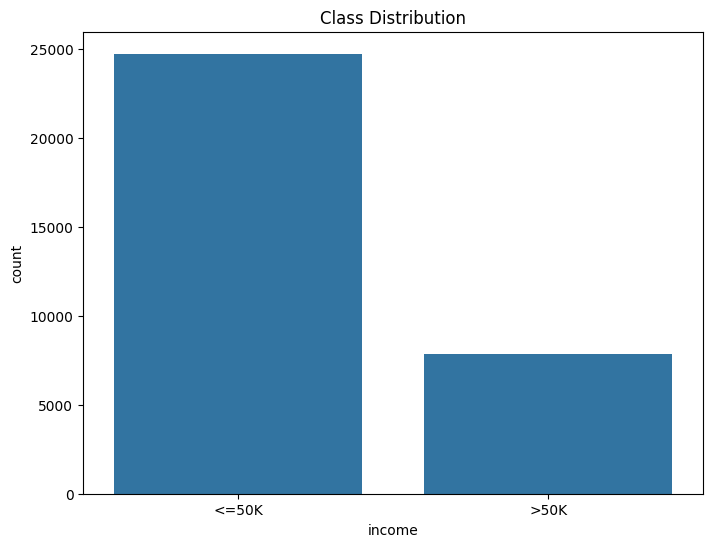

In [17]:
def plot_class_balance(data, title):
    plt.figure(figsize=(8, 6))
    sns.countplot(x='income', data=data)  # 'income' é a variável-alvo
    plt.title(title)
    plt.show()

# Plot para o dataset completo
plot_class_balance(data, 'Class Distribution')


### Now lets see the distribution of the sensitive features
The imbalance present in these features can cause major problems in the model training and testing, because having only a few portion of examples being the minorities of american society means the models don't train on enough data to make accurate and fair predictions. That can lead to racial, gender and nationality bias.

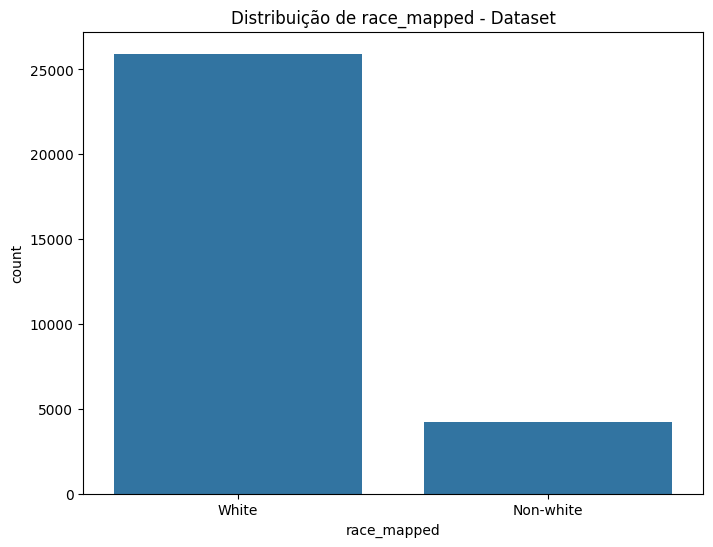

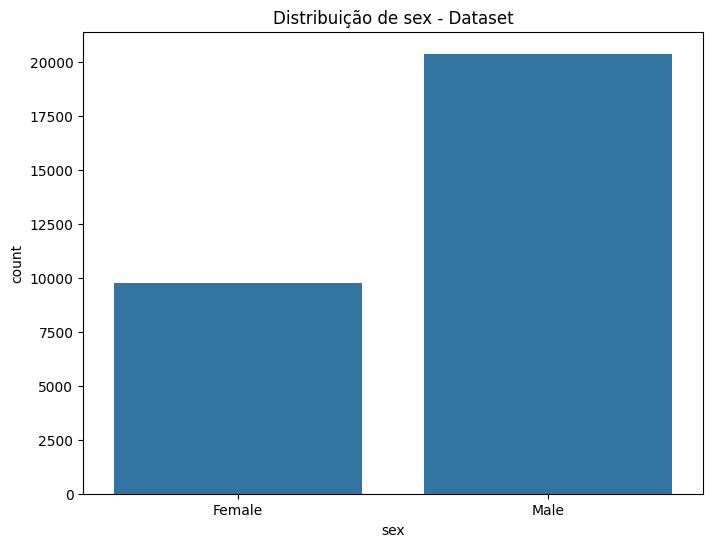

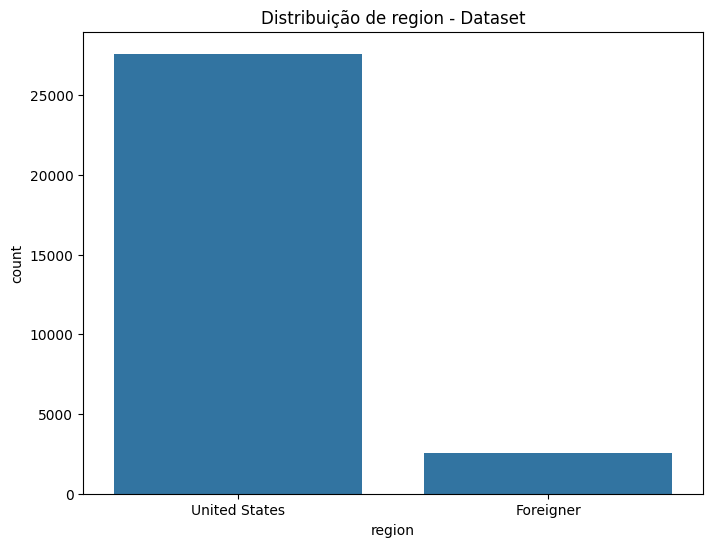

In [18]:
def plot_sensitive_distribution(data, sensitive_attr, title):
    plt.figure(figsize=(8, 6))
    sns.countplot(x=sensitive_attr, data=data)
    plt.title(f'Distribuição de {sensitive_attr} - {title}')
    plt.show()

# Dataset completo
plot_sensitive_distribution(data_filtered, 'race_mapped', 'Dataset')
plot_sensitive_distribution(data_filtered, 'sex', 'Dataset')
plot_sensitive_distribution(data_filtered, 'region', 'Dataset')

In [19]:
df = data_filtered.drop(columns=['native.country', 'race', 'marital.status', 'occupation', 'workclass', 'relationship'])


In [20]:
df = df.reset_index(drop=True)

df.head()

,age,education.num,sex,capital.gain,capital.loss,hours.per.week,income,region,race_mapped,marital,occupation_map,workclass_map,relationship_map
0,82,9,Female,0,4356,18,<=50K,United States,White,Not married,White-collar,Private,Independent
1,54,4,Female,0,3900,40,<=50K,United States,White,Not married,Blue-collar,Private,Independent
2,41,10,Female,0,3900,40,<=50K,United States,White,Not married,White-collar,Private,Child
3,34,9,Female,0,3770,45,<=50K,United States,White,Not married,Service,Private,Independent
4,38,6,Male,0,3770,40,<=50K,United States,White,Not married,White-collar,Private,Independent


## It is also important to see the income distribution between classes
The results show that for every minority, the positive/negative income ratio is even more drastical than between privileged groups

In [21]:
# Analyze sensitive attributes
print("Distribution by race:")
print(df["race_mapped"].value_counts())

print("\nDistribution by sex:")
print(df["sex"].value_counts())

print("\nDistribution by region:")
print(df["region"].value_counts())

# Cross-tabulate sensitive attributes with the target variable
print("\nIncome distribution by race:")
print(pd.crosstab(df["race_mapped"], df["income"], normalize="index"))

print("\nIncome distribution by sex:")
print(pd.crosstab(df["sex"], df["income"], normalize="index"))

print("\nIncome distribution by region:")
print(pd.crosstab(df["region"], df["income"], normalize="index"))

Distribution by race:
race_mapped
White        25933
Non-white     4229
Name: count, dtype: int64

Distribution by sex:
sex
Male      20380
Female     9782
Name: count, dtype: int64

Distribution by region:
region
United States    27611
Foreigner         2551
Name: count, dtype: int64

Income distribution by race:
income          <=50K      >50K
race_mapped                    
Non-white    0.841807  0.158193
White        0.736282  0.263718

Income distribution by sex:
income     <=50K      >50K
sex                       
Female  0.886322  0.113678
Male    0.686163  0.313837

Income distribution by region:
income            <=50K      >50K
region                           
Foreigner      0.813015  0.186985
United States  0.745355  0.254645


## Preparing the data for model training

### Scaling numerical columns and one-hot-encoding the categorical features

In [22]:
# Identify categorical and numerical columns

categorical_cols = df.select_dtypes(include=["object"]).columns

numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns

In [23]:
# One-hot encode categorical columns
from sklearn.preprocessing import OneHotEncoder, StandardScaler

encoder = OneHotEncoder(sparse_output=False, drop="first")  # Updated argument name

df_encoded = pd.DataFrame(
    encoder.fit_transform(df[categorical_cols]), 
    columns=encoder.get_feature_names_out(categorical_cols)
)


In [24]:
# Normalize numerical columns

scaler = StandardScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(df[numerical_cols]), columns=numerical_cols)

In [25]:
df_processed = df_scaled.join(df_encoded)
df_processed = pd.DataFrame(df_processed)

In [26]:
# Separating features and target variable

X = df_processed.drop(columns=["income_>50K"])  # Drop target column

y = df_processed["income_>50K"]


In [27]:
X.head()

,age,education.num,capital.gain,capital.loss,hours.per.week,sex_Male,region_United States,race_mapped_White,marital_Not married,occupation_map_Service,occupation_map_White-collar,workclass_map_Private,workclass_map_Self-employed,relationship_map_Independent,relationship_map_Relative,relationship_map_Spouse
0,3.316630,-0.439738,-0.147445,10.555814,-1.914161,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,1.184831,-2.400559,-0.147445,9.427915,-0.077734,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.195067,-0.047574,-0.147445,9.427915,-0.077734,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,-0.337883,-0.439738,-0.147445,9.106365,0.339636,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,-0.033340,-1.616231,-0.147445,9.106365,-0.077734,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


# The model
## We experimented using two different models: the XGBoost and Decision Tree classifiers.

In [28]:
# Split into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [38]:
# Reset index for all groups
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In order to find the best parameters for the model, we performed a grid search

In [39]:
# Initialize the XGBoost classifier
model_pre = XGBClassifier(
    eval_metric="logloss",    # Set evaluation metric
    random_state=42,
    n_estimators=100,         # Number of boosting rounds
    learning_rate=0.1,        # Step size shrinkage
    max_depth=6,              # Maximum depth of trees
    subsample=0.8,            # Fraction of samples used for training
    colsample_bytree=0.8      # Fraction of features used for training
)

# Train the model on the oversampled training set
model_pre.fit(X_train, y_train)

# Test the model
y_pred_pre = model_pre.predict(X_test)

# Evaluate performance
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred_pre))
print("Accuracy (Test Set):", accuracy_score(y_test, y_pred_pre))

Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.92      6797
         1.0       0.79      0.64      0.71      2252

    accuracy                           0.87      9049
   macro avg       0.84      0.79      0.81      9049
weighted avg       0.86      0.87      0.86      9049

Accuracy (Test Set): 0.8691568129075036


### Calculating fariness metrics each sensitive feature
These metrics allow us to evaluate the fairness in the model's predictions. The model will be evaluated in Disparate Impact, Equality of Opportunity Difference and True Positive Rate.

In [44]:
def calculate_disparate_impact_subset(y_true, sensitive_feature_values, privileged_group, positive_outcome):
    """
    Calculate Disparate Impact (DI) for a given dataset subset.
    """
    privileged = sensitive_feature_values == privileged_group
    unprivileged = ~privileged

    # Calculate positive outcome rates
    privileged_rate = (y_true[privileged] == positive_outcome).mean()
    unprivileged_rate = (y_true[unprivileged] == positive_outcome).mean()

    # Safeguard for division by zero
    if privileged_rate == 0 or unprivileged_rate == 0:
        return 0  # Return 0 or another meaningful value

    return unprivileged_rate / privileged_rate

# Extract sensitive feature values for training data
race_mapped_train = X_train.loc[y_train.index, "race_mapped_White"]

# Calculate DI for race
di_race = calculate_disparate_impact_subset(
    y_true=y_train,
    sensitive_feature_values=race_mapped_train,
    privileged_group=1,
    positive_outcome=1
)
print("\nDisparate Impact (Race):", di_race)

# Extract sensitive feature values for training data
sex_train = X_train.loc[y_train.index, "sex_Male"]

# Calculate DI for sex
di_sex = calculate_disparate_impact_subset(
    y_true=y_train,
    sensitive_feature_values=sex_train,
    privileged_group=1,
    positive_outcome=1
)
print("\nDisparate Impact (Sex):", di_sex)

# Extract sensitive feature values for training data
region_train = X_train.loc[y_train.index, "region_United States"]

# Calculate DI for race
di_region = calculate_disparate_impact_subset(
    y_true=y_train,
    sensitive_feature_values=region_train,
    privileged_group=1,
    positive_outcome=1
)
print("\nDisparate Impact (Region):", di_region)

y_pred_train = model_pre.predict(X_train)


Disparate Impact (Race): 0.5869096595502414

Disparate Impact (Sex): 0.3651704864740436

Disparate Impact (Region): 0.7602075054674209


In [46]:
from sklearn.metrics import recall_score

def calculate_eod(y_true, y_pred, sensitive_feature, privileged_group):
    privileged = X_train.loc[y_true.index, sensitive_feature] == privileged_group
    unprivileged = ~privileged

    privileged_tpr = recall_score(y_true[privileged], y_pred[privileged])
    unprivileged_tpr = recall_score(y_true[unprivileged], y_pred[unprivileged])

    return privileged_tpr - unprivileged_tpr

# Calculate EOD for race
eod_race = calculate_eod(
    y_true=y_train,
    y_pred=y_pred_train,
    sensitive_feature="race_mapped_White",
    privileged_group=1
)
print("\nEquality of Opportunity Difference (Race):", eod_race)

# Calculate EOD for sex
eod_sex = calculate_eod(
    y_true=y_train,
    y_pred=y_pred_train,
    sensitive_feature="sex_Male",
    privileged_group=1
)
print("\nEquality of Opportunity Difference (Sex):", eod_sex)

# Calculate EOD for region
eod_region = calculate_eod(
    y_true=y_train,
    y_pred=y_pred_train,
    sensitive_feature="region_United States",
    privileged_group=1
)
print("\nEquality of Opportunity Difference (Region):", eod_region)


Equality of Opportunity Difference (Race): 0.0692158011324997

Equality of Opportunity Difference (Sex): 0.03245186299415126

Equality of Opportunity Difference (Region): 0.02419413384327984


In [48]:
# Debug TPRs
privileged_mask_race = X_train.loc[y_train.index, "race_mapped_White"] == 1
unprivileged_mask_race = ~privileged_mask_race

privileged_tpr_race = recall_score(y_train[privileged_mask_race], y_pred_train[privileged_mask_race])
unprivileged_tpr_race = recall_score(y_train[unprivileged_mask_race], y_pred_train[unprivileged_mask_race])

print(f"Privileged TPR Race: {privileged_tpr_race}")
print(f"Unprivileged TPR Race: {unprivileged_tpr_race}")

# Debug TPRs
privileged_mask_sex = X_train.loc[y_train.index, "sex_Male"] == 1
unprivileged_mask_sex = ~privileged_mask_sex

privileged_tpr_sex = recall_score(y_train[privileged_mask_sex], y_pred_train[privileged_mask_sex])
unprivileged_tpr_sex = recall_score(y_train[unprivileged_mask_sex], y_pred_train[unprivileged_mask_sex])

print(f"Privileged TPR Sex: {privileged_tpr_sex}")
print(f"Unprivileged TPR Sex: {unprivileged_tpr_sex}")

# Debug TPRs
privileged_mask_region = X_train.loc[y_train.index, "region_United States"] == 1
unprivileged_mask_region = ~privileged_mask_region

privileged_tpr_region = recall_score(y_train[privileged_mask_region], y_pred_train[privileged_mask_region])
unprivileged_tpr_region = recall_score(y_train[unprivileged_mask_region], y_pred_train[unprivileged_mask_region])

print(f"Privileged TPR Region: {privileged_tpr_region}")
print(f"Unprivileged TPR Region: {unprivileged_tpr_region}")


Privileged TPR Race: 0.6606136505948653
Unprivileged TPR Race: 0.5913978494623656
Privileged TPR Sex: 0.6593554162936437
Unprivileged TPR Sex: 0.6269035532994924
Privileged TPR Region: 0.6560781918142944
Unprivileged TPR Region: 0.6318840579710145


### Understanding bias metrics
Bias metrics are critical tools for evaluating the fairness of machine learning models, especially when dealing with sensitive attributes such as race, gender, or region. These metrics help identify disparities in model performance and outcomes across different groups, guiding efforts to mitigate bias.

#### Disparate impact: 
Measures the ratio of positive outcomes for an unprivileged group compared to a privileged group. A value close to 1 indicates fairness, while values significantly below or above 1 suggest potential bias.
#### Equality of Opportunity Difference (EOD):
Focuses on the difference in True Positive Rates (TPR) between privileged and unprivileged groups. A low EOD value indicates that the model performs equally well across groups in predicting positive outcomes.



### Lets see confusion matrices to understand the true/negatives positive and negative predictions

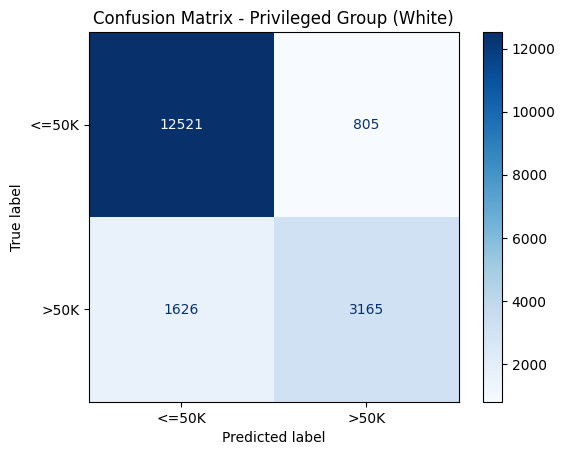

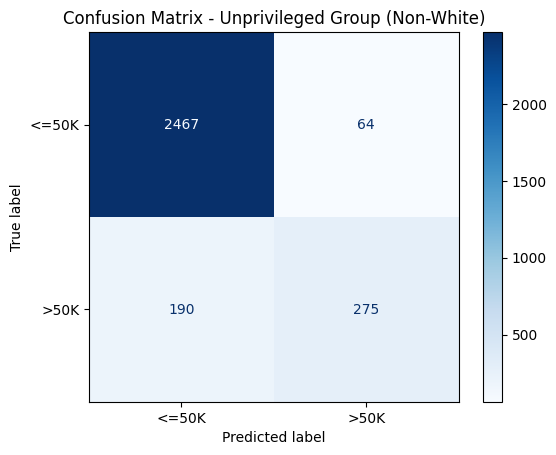

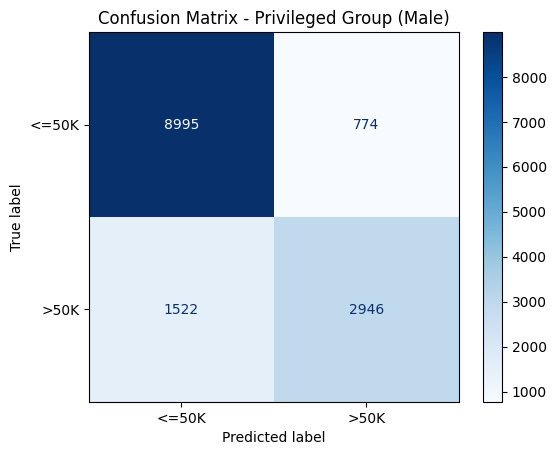

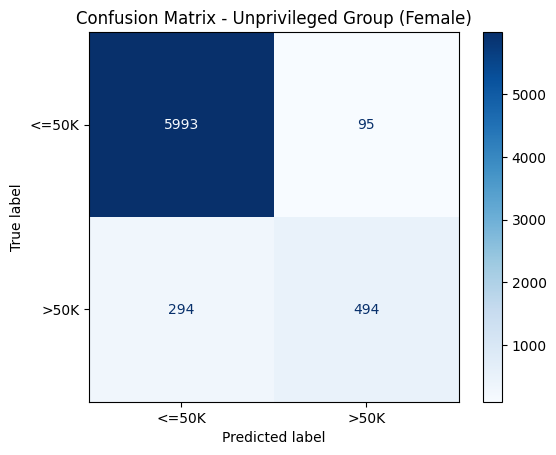

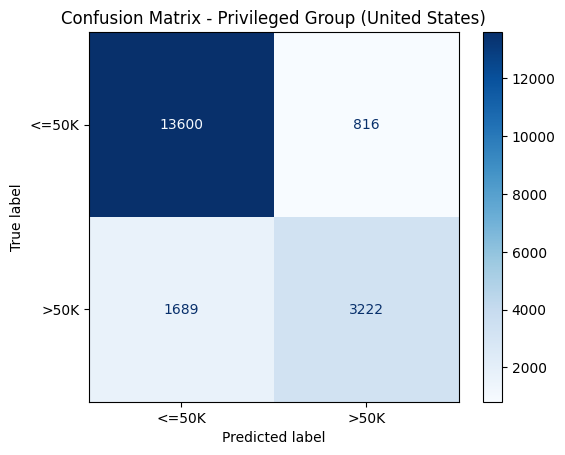

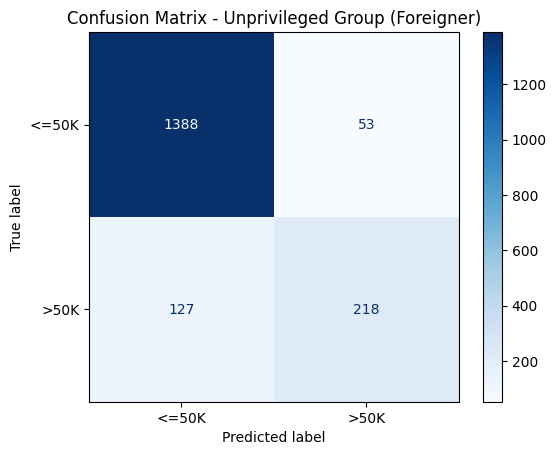

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Privileged group confusion matrix
privileged_cm_race = confusion_matrix(y_train[privileged_mask_race], y_pred_train[privileged_mask_race])
disp_privileged_race = ConfusionMatrixDisplay(confusion_matrix=privileged_cm_race, display_labels=["<=50K", ">50K"])
disp_privileged_race.plot(cmap="Blues")
plt.title("Confusion Matrix - Privileged Group (White)")
plt.show()

# Unprivileged group confusion matrix
unprivileged_cm_race = confusion_matrix(y_train[unprivileged_mask_race], y_pred_train[unprivileged_mask_race])
disp_unprivileged_race = ConfusionMatrixDisplay(confusion_matrix=unprivileged_cm_race, display_labels=["<=50K", ">50K"])
disp_unprivileged_race.plot(cmap="Blues")
plt.title("Confusion Matrix - Unprivileged Group (Non-White)")
plt.show()

# Privileged group confusion matrix
privileged_cm_sex = confusion_matrix(y_train[privileged_mask_sex], y_pred_train[privileged_mask_sex])
disp_privileged_sex = ConfusionMatrixDisplay(confusion_matrix=privileged_cm_sex, display_labels=["<=50K", ">50K"])
disp_privileged_sex.plot(cmap="Blues")
plt.title("Confusion Matrix - Privileged Group (Male)")
plt.show()

# Unprivileged group confusion matrix
unprivileged_cm_sex = confusion_matrix(y_train[unprivileged_mask_sex], y_pred_train[unprivileged_mask_sex])
disp_unprivileged_sex = ConfusionMatrixDisplay(confusion_matrix=unprivileged_cm_sex, display_labels=["<=50K", ">50K"])
disp_unprivileged_sex.plot(cmap="Blues")
plt.title("Confusion Matrix - Unprivileged Group (Female)")
plt.show()

# Privileged group confusion matrix
privileged_cm_region = confusion_matrix(y_train[privileged_mask_region], y_pred_train[privileged_mask_region])
disp_privileged_region = ConfusionMatrixDisplay(confusion_matrix=privileged_cm_region, display_labels=["<=50K", ">50K"])
disp_privileged_region.plot(cmap="Blues")
plt.title("Confusion Matrix - Privileged Group (United States)")
plt.show()

# Unprivileged group confusion matrix
unprivileged_cm_region = confusion_matrix(y_train[unprivileged_mask_region], y_pred_train[unprivileged_mask_region])
disp_unprivileged_region = ConfusionMatrixDisplay(confusion_matrix=unprivileged_cm_region, display_labels=["<=50K", ">50K"])
disp_unprivileged_region.plot(cmap="Blues")
plt.title("Confusion Matrix - Unprivileged Group (Foreigner)")
plt.show()


### Mitigation in all the sensitive features
To Increase the effectiveness of the oversampling in all the sensitive features instead of only one of them we made a composite feature that includes all of them.

In [53]:
# Identify binary columns in the dataset
binary_columns = [
    col for col in X_train.columns 
    if set(X_train[col].unique()).issubset({0, 1})
]
print("Binary Columns:", binary_columns)


Binary Columns: ['sex_Male', 'region_United States', 'race_mapped_White', 'marital_Not married', 'occupation_map_Service', 'occupation_map_White-collar', 'workclass_map_Private', 'workclass_map_Self-employed', 'relationship_map_Independent', 'relationship_map_Relative', 'relationship_map_Spouse']


In [54]:
# Combine sensitive classes into one column
X_train["joint_sensitive_class"] = (
    X_train["race_mapped_White"].map({1: "White", 0: "Non-White"}) + "_" +
    X_train["sex_Male"].map({1: "Male", 0: "Female"}) + "_" +
    X_train["region_United States"].map({1: "United States", 0: "Other"})
)

# Check the distribution of joint sensitive groups
print("Joint Sensitive Class Distribution:\n", X_train["joint_sensitive_class"].value_counts())


Joint Sensitive Class Distribution:
 joint_sensitive_class
White_Male_United States          11804
White_Female_United States         5190
Non-White_Male_United States       1228
Non-White_Female_United States     1105
White_Male_Other                    772
Non-White_Male_Other                433
White_Female_Other                  351
Non-White_Female_Other              230
Name: count, dtype: int64


### Adding the target to the composite feature
And to balance the features with an equilibrium of both positive and negative target labels we add the target to the composite feature as not to inroduce oversampling of only negative or positive examples

In [55]:
trainset = X_train.join(y_train)
trainset['income'] = trainset['income_>50K'].map({0: "false", 1: "true"}) 
trainset.head()

,age,education.num,capital.gain,capital.loss,hours.per.week,sex_Male,region_United States,race_mapped_White,marital_Not married,occupation_map_Service,occupation_map_White-collar,workclass_map_Private,workclass_map_Self-employed,relationship_map_Independent,relationship_map_Relative,relationship_map_Spouse,joint_sensitive_class,income_>50K,income
0,-0.794697,-0.047574,-0.147445,-0.218586,-0.912474,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,White_Female_United States,0.0,false
1,0.499610,-0.439738,-0.147445,-0.218586,0.590057,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,White_Male_United States,0.0,false
2,0.728017,-0.047574,-0.147445,-0.218586,-0.077734,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,White_Male_United States,0.0,false
3,0.423474,-0.047574,-0.147445,-0.218586,-0.077734,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,White_Female_United States,0.0,false
4,0.118931,-0.439738,-0.147445,-0.218586,-0.077734,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,Non-White_Male_United States,0.0,false


#### Why is this composite taarget being created?
ADASYN oversampled the data focusin on balancing the provided 'y'. By creating a target that contains race, sex, region and income and providing it as the 'y' to ADASYN, it will try balance every sensitive feature as well as the income (label). But it is important to remember that this approach focuses on maximizing fairness without compromising performance, hence the "minority" sampling strategy, this guarantees that the minority classes in 'y' are more intensively oversampled, but maintaining a certain "real" factor in the data. This is what guarantees that performance is not compromised.

In [56]:
trainset["composite_target"] = (
trainset["joint_sensitive_class"] + "_" + trainset["income"]
)
print(trainset["composite_target"].value_counts())

composite_target
White_Male_United States_false          7867
White_Female_United States_false        4524
White_Male_United States_true           3937
Non-White_Female_United States_false    1038
Non-White_Male_United States_false       987
White_Female_United States_true          666
White_Male_Other_false                   615
White_Female_Other_false                 320
Non-White_Male_Other_false               300
Non-White_Male_United States_true        241
Non-White_Female_Other_false             206
White_Male_Other_true                    157
Non-White_Male_Other_true                133
Non-White_Female_United States_true       67
White_Female_Other_true                   31
Non-White_Female_Other_true               24
Name: count, dtype: int64


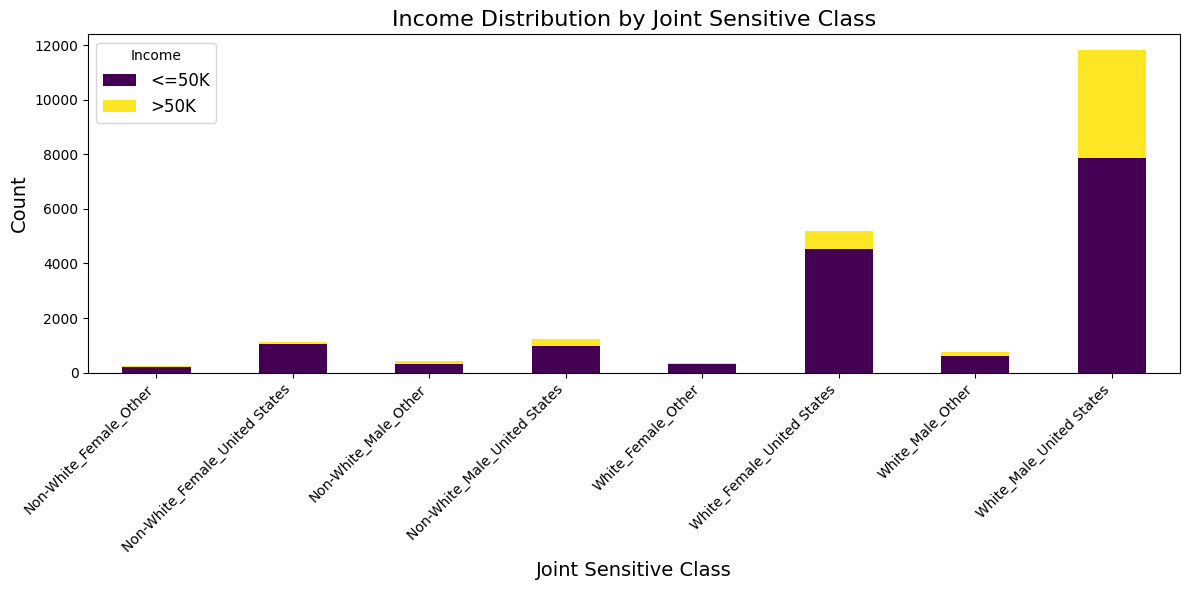

In [57]:
# Group the data by sensitive class and income
distribution_data = (
    trainset.groupby(["joint_sensitive_class", "income"])
    .size()
    .unstack(fill_value=0)
)

# Plot the stacked bar chart
ax = distribution_data.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis")
plt.title("Income Distribution by Joint Sensitive Class", fontsize=16)
plt.xlabel("Joint Sensitive Class", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(["<=50K", ">50K"], title="Income", fontsize=12)
plt.tight_layout()
plt.show()

## Oversampling with ADASYN

In [58]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(sampling_strategy="minority", random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(trainset.drop(columns=['joint_sensitive_class', 'income', 'composite_target']), trainset['composite_target'])

# Validate new distributions
print("New class distribution:")
print(pd.Series(y_resampled).value_counts())

New class distribution:
composite_target
Non-White_Female_Other_true             7868
White_Male_United States_false          7867
White_Female_United States_false        4524
White_Male_United States_true           3937
Non-White_Female_United States_false    1038
Non-White_Male_United States_false       987
White_Female_United States_true          666
White_Male_Other_false                   615
White_Female_Other_false                 320
Non-White_Male_Other_false               300
Non-White_Male_United States_true        241
Non-White_Female_Other_false             206
White_Male_Other_true                    157
Non-White_Male_Other_true                133
Non-White_Female_United States_true       67
White_Female_Other_true                   31
Name: count, dtype: int64


### Comparing the values of each feature pre and post balancing 

In [119]:
print("Pre oversampling: \n")
print(pd.Series(X_train["race_mapped_White"].value_counts()))
print("\nPost oversampling: \n")
print(pd.Series(X_resampled["race_mapped_White"].value_counts()))

Pre oversampling: 

race_mapped_White
1.0    18117
0.0     2996
Name: count, dtype: int64

Post oversampling: 

race_mapped_White
1.0    18117
0.0    10840
Name: count, dtype: int64


In [120]:
print("Pre oversampling: \n")
print(pd.Series(X_train["region_United States"].value_counts()))
print("\nPost oversampling: \n")
print(pd.Series(X_resampled["region_United States"].value_counts()))

Pre oversampling: 

region_United States
1.0    19327
0.0     1786
Name: count, dtype: int64

Post oversampling: 

region_United States
1.0    19327
0.0     9630
Name: count, dtype: int64


In [121]:
print("Pre oversampling: \n")
print(pd.Series(X_train["sex_Male"].value_counts()))
print("\nPost oversampling: \n")
print(pd.Series(X_resampled["sex_Male"].value_counts()))

Pre oversampling: 

sex_Male
1.0    14237
0.0     6876
Name: count, dtype: int64

Post oversampling: 

sex_Male
0.0    14720
1.0    14237
Name: count, dtype: int64


In [122]:
print("Pre oversampling: \n")
print(pd.Series(y_train.value_counts()))
print("\nPost oversampling: \n")
print(pd.Series(X_resampled["income_>50K"].value_counts()))

Pre oversampling: 

income_>50K
0.0    15857
1.0     5256
Name: count, dtype: int64

Post oversampling: 

income_>50K
0.0    15857
1.0    13100
Name: count, dtype: int64


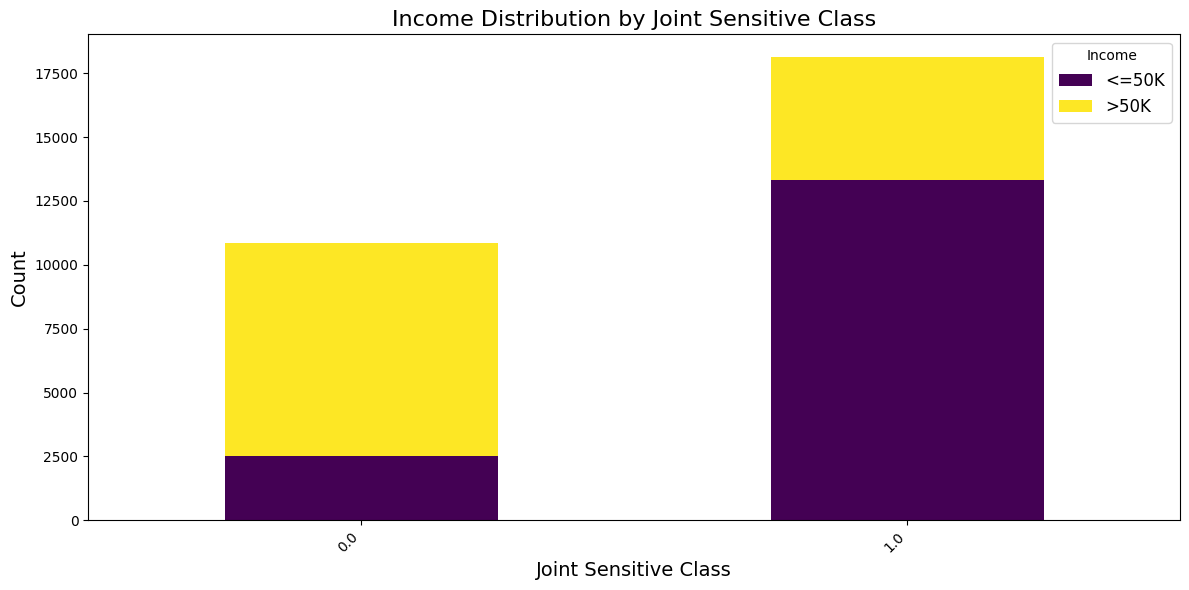

In [123]:
# Group the data by sensitive class and income
distribution_data = (
    X_resampled.groupby(["race_mapped_White", "income_>50K"])
    .size()
    .unstack(fill_value=0)
)

# Plot the stacked bar chart
ax = distribution_data.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis")
plt.title("Income Distribution by Joint Sensitive Class", fontsize=16)
plt.xlabel("Joint Sensitive Class", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(["<=50K", ">50K"], title="Income", fontsize=12)
plt.tight_layout()
plt.show()

## Preparing for the post oversampling model

In [124]:
columns = X_test.columns

In [125]:
X_train_final = X_resampled[columns]

In [126]:
y_train_final = X_resampled['income_>50K']

In [71]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Initialize the XGBoost classifier
xgb_model = XGBClassifier(
    eval_metric="logloss",    # Set evaluation metric
    random_state=42,
    n_estimators=100,         # Number of boosting rounds
    learning_rate=0.1,        # Step size shrinkage
    max_depth=6,              # Maximum depth of trees
    subsample=0.8,            # Fraction of samples used for training
    colsample_bytree=0.8      # Fraction of features used for training
)

# Train the model on the oversampled training set
xgb_model.fit(X_train_final, y_train_final)

# Test the model
y_pred_test = xgb_model.predict(X_test)

# Evaluate performance
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred_test))
print("Accuracy (Test Set):", accuracy_score(y_test, y_pred_test))


Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91      6797
         1.0       0.78      0.64      0.70      2252

    accuracy                           0.87      9049
   macro avg       0.83      0.79      0.81      9049
weighted avg       0.86      0.87      0.86      9049

Accuracy (Test Set): 0.8656205105536523


## Calculating selection rate (ratio of entries predicted as true/predicted as false) and other fairness metrics

In [72]:
def calculate_selection_rate(y_pred, sensitive_features, group_value):
    # Filter for the specific group
    group_mask = sensitive_features == group_value
    group_size = group_mask.sum()  # Total number of individuals in the group
    positive_predictions = (y_pred[group_mask] == 1).sum()  # Positive predictions for the group
    
    # Calculate selection rate
    return positive_predictions / group_size if group_size > 0 else 0


In [133]:
sensitive_groups = X_test["sex_Male"].unique()  # Example for sex-sensitive attribute
for group in sensitive_groups:
    selection_rate = calculate_selection_rate(y_pred_pre, X_test["sex_Male"], group)
    print(f"Selection Rate Pre ADASYN (Sex = {group}): {selection_rate:.4f}")
for group in sensitive_groups:
    selection_rate = calculate_selection_rate(y_pred_test, X_test["sex_Male"], group)
    print(f"Selection Rate Post ADASYN (Sex = {group}): {selection_rate:.4f}")

print("-"*50)
sensitive_groups = X_test["race_mapped_White"].unique()  # Example for sex-sensitive attribute
for group in sensitive_groups:
    selection_rate = calculate_selection_rate(y_pred_pre, X_test["race_mapped_White"], group)
    print(f"Selection Rate Pre ADASYN(race = {group}): {selection_rate:.4f}")
for group in sensitive_groups:
    selection_rate = calculate_selection_rate(y_pred_test, X_test["race_mapped_White"], group)
    print(f"Selection Rate Post ADASYN (race = {group}): {selection_rate:.4f}")
print("-"*50)
sensitive_groups = X_test["region_United States"].unique()  # Example for sex-sensitive attribute
for group in sensitive_groups:
    selection_rate = calculate_selection_rate(y_pred_pre, X_test["region_United States"], group)
    print(f"Selection Rate Pre ADASYN (region = {group}): {selection_rate:.4f}")
for group in sensitive_groups:
    selection_rate = calculate_selection_rate(y_pred_test, X_test["region_United States"], group)
    print(f"Selection Rate Post ADASYN (region = {group}): {selection_rate:.4f}")


Selection Rate Pre ADASYN (Sex = 1.0): 0.2549
Selection Rate Pre ADASYN (Sex = 0.0): 0.0881
Selection Rate Post ADASYN (Sex = 1.0): 0.2535
Selection Rate Post ADASYN (Sex = 0.0): 0.1001
--------------------------------------------------
Selection Rate Pre ADASYN(race = 1.0): 0.2142
Selection Rate Pre ADASYN(race = 0.0): 0.1200
Selection Rate Post ADASYN (race = 1.0): 0.2139
Selection Rate Post ADASYN (race = 0.0): 0.1427
--------------------------------------------------
Selection Rate Pre ADASYN (region = 0.0): 0.1516
Selection Rate Pre ADASYN (region = 1.0): 0.2059
Selection Rate Post ADASYN (region = 0.0): 0.1908
Selection Rate Post ADASYN (region = 1.0): 0.2055


In [140]:
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference

# Define sensitive features
race = X_test["race_mapped_White"]
region = X_test["region_United States"]
sex = X_test["sex_Male"]
# Evaluate performance by sensitive groups
mf = MetricFrame(
    metrics={"Accuracy": accuracy_score},
    y_true=y_test,
    y_pred=y_pred_test,
    sensitive_features=sex
)
mf2 = MetricFrame(
    metrics={"Accuracy": accuracy_score},
    y_true=y_test,
    y_pred=y_pred_test,
    sensitive_features=race
)
mf3 = MetricFrame(
    metrics={"Accuracy": accuracy_score},
    y_true=y_test,
    y_pred=y_pred_test,
    sensitive_features=region
)

# Print metrics by group
print("\nPerformance by Sensitive Group (sex):")
print(mf.by_group)

# Fairness metrics
dp_diff = demographic_parity_difference(y_test, y_pred_test, sensitive_features=sex)
eod_diff = equalized_odds_difference(y_test, y_pred_test, sensitive_features=sex)
print(f"Demographic Parity Difference: {dp_diff:.4f}")
print(f"Equalized Odds Difference: {eod_diff:.4f}")
print("\nPerformance by Sensitive Group (race):")
print(mf2.by_group)
# Fairness metrics
dp_diff2 = demographic_parity_difference(y_test, y_pred_test, sensitive_features=race)
eod_diff2 = equalized_odds_difference(y_test, y_pred_test, sensitive_features=race)
print(f"Demographic Parity Difference: {dp_diff:.4f}")
print(f"Equalized Odds Difference: {eod_diff:.4f}")
print("\nPerformance by Sensitive Group (region):")
print(mf3.by_group)

# Fairness metrics
dp_diff3 = demographic_parity_difference(y_test, y_pred_test, sensitive_features=region)
eod_diff3 = equalized_odds_difference(y_test, y_pred_test, sensitive_features=region)

print(f"Demographic Parity Difference: {dp_diff3:.4f}")
print(f"Equalized Odds Difference: {eod_diff3:.4f}")


Performance by Sensitive Group (sex):
          Accuracy
sex_Male          
0.0       0.922574
1.0       0.838678
Demographic Parity Difference: 0.1533
Equalized Odds Difference: 0.0449

Performance by Sensitive Group (race):
                   Accuracy
race_mapped_White          
0.0                0.886456
1.0                0.862334
Demographic Parity Difference: 0.1533
Equalized Odds Difference: 0.0449

Performance by Sensitive Group (region):
                      Accuracy
region_United States          
0.0                   0.879739
1.0                   0.864317
Demographic Parity Difference: 0.0146
Equalized Odds Difference: 0.0682


In [79]:
from sklearn.metrics import confusion_matrix

# Function to calculate Disparate Impact
def calculate_disparate_impact(y_true, y_pred, sensitive_features, privileged_group, positive_outcome=1):
    privileged_mask = sensitive_features == privileged_group
    unprivileged_mask = ~privileged_mask

    privileged_positive_rate = (y_pred[privileged_mask] == positive_outcome).mean()
    unprivileged_positive_rate = (y_pred[unprivileged_mask] == positive_outcome).mean()

    if privileged_positive_rate == 0:  # Prevent division by zero
        return None
    return unprivileged_positive_rate / privileged_positive_rate

# Calculate Disparate Impact for each sensitive feature
di_sex = calculate_disparate_impact(y_test, y_pred_test, X_test["sex_Male"], privileged_group=1)
di_race = calculate_disparate_impact(y_test, y_pred_test, X_test["race_mapped_White"], privileged_group=1)
di_region = calculate_disparate_impact(y_test, y_pred_test, X_test["region_United States"], privileged_group=1)

print("Disparate Impact (Sex):", di_sex)
print("Disparate Impact (Race):", di_race)
print("Disparate Impact (Region):", di_region)


Disparate Impact (Sex): 0.3950838541480188
Disparate Impact (Race): 0.6672642677252743
Disparate Impact (Region): 0.9289064000061442


In [80]:
# Function to display confusion matrix by group
def confusion_matrix_by_group(y_true, y_pred, sensitive_features, group_value):
    group_mask = sensitive_features == group_value
    return confusion_matrix(y_true[group_mask], y_pred[group_mask])

# Confusion Matrices for each sensitive feature
print("Confusion Matrix (Sex = Male):")
print(confusion_matrix_by_group(y_test, y_pred_test, X_test["sex_Male"], group_value=1))

print("\nConfusion Matrix (Sex = Female):")
print(confusion_matrix_by_group(y_test, y_pred_test, X_test["sex_Male"], group_value=0))

print("\nConfusion Matrix (Race = White):")
print(confusion_matrix_by_group(y_test, y_pred_test, X_test["race_mapped_White"], group_value=1))

print("\nConfusion Matrix (Race = Non-White):")
print(confusion_matrix_by_group(y_test, y_pred_test, X_test["race_mapped_White"], group_value=0))

print("\nConfusion Matrix (Region = United States):")
print(confusion_matrix_by_group(y_test, y_pred_test, X_test["region_United States"], group_value=1))

print("\nConfusion Matrix (Region = Other):")
print(confusion_matrix_by_group(y_test, y_pred_test, X_test["region_United States"], group_value=0))


Confusion Matrix (Sex = Male):
[[3905  310]
 [ 681 1247]]

Confusion Matrix (Sex = Female):
[[2486   96]
 [ 129  195]]

Confusion Matrix (Race = White):
[[5418  350]
 [ 726 1322]]

Confusion Matrix (Race = Non-White):
[[973  56]
 [ 84 120]]

Confusion Matrix (Region = United States):
[[5811  353]
 [ 771 1349]]

Confusion Matrix (Region = Other):
[[580  53]
 [ 39  93]]


In [81]:
# Function to calculate TPR by group
from sklearn.metrics import recall_score

def tpr_by_group(y_true, y_pred, sensitive_features, group_value):
    group_mask = sensitive_features == group_value
    return recall_score(y_true[group_mask], y_pred[group_mask])

# TPR for each sensitive feature
print("True Positive Rate (Sex = Male):", tpr_by_group(y_test, y_pred_test, X_test["sex_Male"], group_value=1))
print("True Positive Rate (Sex = Female):", tpr_by_group(y_test, y_pred_test, X_test["sex_Male"], group_value=0))

print("True Positive Rate (Race = White):", tpr_by_group(y_test, y_pred_test, X_test["race_mapped_White"], group_value=1))
print("True Positive Rate (Race = Non-White):", tpr_by_group(y_test, y_pred_test, X_test["race_mapped_White"], group_value=0))

print("True Positive Rate (Region = United States):", tpr_by_group(y_test, y_pred_test, X_test["region_United States"], group_value=1))
print("True Positive Rate (Region = Other):", tpr_by_group(y_test, y_pred_test, X_test["region_United States"], group_value=0))


True Positive Rate (Sex = Male): 0.6467842323651453
True Positive Rate (Sex = Female): 0.6018518518518519
True Positive Rate (Race = White): 0.6455078125
True Positive Rate (Race = Non-White): 0.5882352941176471
True Positive Rate (Region = United States): 0.6363207547169811
True Positive Rate (Region = Other): 0.7045454545454546


In [84]:
from fairlearn.postprocessing import ThresholdOptimizer
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="fairlearn.postprocessing")

# Create the ThresholdOptimizer object
threshold_optimizer = ThresholdOptimizer(
    estimator=xgb_model,  # Trained model
    constraints="equalized_odds",  
    predict_method="predict_proba"  
)

# Fit the ThresholdOptimizer
threshold_optimizer.fit(X_test, y_test, sensitive_features=X_test["race_mapped_White"])

# Make predictions with sensitive features
predictions_adjusted = threshold_optimizer.predict(
    X_test, sensitive_features=X_test["race_mapped_White"]
)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions_adjusted)
print(f"Post-Processed Accuracy: {accuracy:.4f}")


Post-Processed Accuracy: 0.8872


### Using aequitas flow to evaluate more fairness metrics

In [104]:
import pandas as pd

# Prepare Aequitas-compatible DataFrame
aequitas_df = pd.DataFrame({
    'score': y_pred_test,  # Model predictions
    'label_value': y_test,  # True labels
    'race': X_test['race_mapped_White'],  # Sensitive attribute
    'sex': X_test['sex_Male'],
    'country': X_test['region_United States']
})

print(aequitas_df.head())


   score  label_value  race  sex  country
0      0          0.0   1.0  1.0      0.0
1      0          0.0   1.0  1.0      0.0
2      1          1.0   1.0  1.0      1.0
3      0          0.0   0.0  0.0      1.0
4      0          0.0   1.0  1.0      1.0


In [141]:
aequitas_df['sex'] = aequitas_df['sex'].astype(str)
aequitas_df['race'] = aequitas_df['race'].astype(str)
aequitas_df['country'] = aequitas_df['country'].astype(str)
print(aequitas_df.info())
print(aequitas_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9049 entries, 0 to 9048
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   score        9049 non-null   int64  
 1   label_value  9049 non-null   float64
 2   race         9049 non-null   object 
 3   sex          9049 non-null   object 
 4   country      9049 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 353.6+ KB
None
   score  label_value race  sex country
0      0          0.0  1.0  1.0     0.0
1      0          0.0  1.0  1.0     0.0
2      1          1.0  1.0  1.0     1.0
3      0          0.0  0.0  0.0     1.0
4      0          0.0  1.0  1.0     1.0


In [112]:
from aequitas.group import Group
from aequitas.bias import Bias


# Calculate group metrics
g = Group()
group_metrics, _ = g.get_crosstabs(aequitas_df)  # Extract the first element

# Calculate bias metrics
b = Bias()
bias_metrics = b.get_disparity_major_group(
    df=group_metrics,
    original_df=aequitas_df
)

print("\nBias Metrics:")
pd.set_option('display.max_columns', None)
bias_metrics

get_disparity_major_group()

Bias Metrics:


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,0,binary 0/1,1848,race,0.0,0.588235,0.945578,0.079470,0.318182,0.054422,0.411765,0.920530,0.681818,176,1057,0.095238,0.142741,56,84,973,120,204,1029,1233,9049,0.165450,0.105263,0.667264,0.862330,1.520000,0.672541,0.896871,1.161562,0.911275,1.006662,1.043879,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0,binary 0/1,1848,race,1.0,0.645508,0.939320,0.118164,0.209330,0.060680,0.354492,0.881836,0.790670,1672,6144,0.904762,0.213920,350,726,5418,1322,2048,5768,7816,9049,0.262027,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0,binary 0/1,1848,sex,0.0,0.601852,0.962820,0.049331,0.329897,0.037180,0.398148,0.950669,0.670103,291,2615,0.157468,0.100138,96,129,2486,195,324,2582,2906,9049,0.111493,0.186898,0.395084,0.836688,1.656934,0.332204,0.505535,1.127209,0.930530,1.039253,1.116458,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0,binary 0/1,1848,sex,1.0,0.646784,0.926453,0.148495,0.199101,0.073547,0.353216,0.851505,0.800899,1557,4586,0.842532,0.253459,310,681,3905,1247,1928,4215,6143,9049,0.313853,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0,binary 0/1,1848,country,0.0,0.704545,0.916272,0.063005,0.363014,0.083728,0.295455,0.936995,0.636986,146,619,0.079004,0.190850,53,39,580,93,132,633,765,9049,0.172549,0.085781,0.928906,0.803670,1.750281,0.537870,1.462043,0.812404,1.107217,0.971932,1.061315,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,0,binary 0/1,1848,country,1.0,0.636321,0.942732,0.117138,0.207403,0.057268,0.363679,0.882862,0.792597,1702,6582,0.920996,0.205456,353,771,5811,1349,2120,6164,8284,9049,0.255915,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Analysis of metrics
The application of ADASYN demonstrated a focused attempt to reduce bias across sensitive groups while striving to maintain overall model performance. By dynamically generating synthetic samples for underrepresented groups, ADASYN ensured a more balanced representation in the training data.

The tradeoff between fairness and performance underscores the effectiveness of ADASYN in achieving a more equitable model without heavily compromising its predictive capabilities (moving the accuracy from 86.92% pre-ADASYN to 86.56% post-ADASYN). This approach highlights the importance of balancing fairness objectives with performance requirements in practical machine learning applications.

### Lets analyse with numbers

Disparate Impact (DI):
    Race: Improved from 0.5869 to 0.6673, indicating a more balanced distribution of positive predictions between White and Non-White groups.
    Sex: Increased from 0.3652 to 0.3951, narrowing the gap in predictions between Male and Female groups.
    Region: Improved from 0.7602 to 0.9289, significantly enhancing fairness between U.S. residents and foreigners.

Equality of Opportunity Difference (EOD):
    Race: Reduced from 0.0692 to 0.0562, reflecting a smaller disparity in True Positive Rates (TPR) between privileged and underprivileged racial groups.
    Sex: Improved from 0.0325 to 0.0297, achieving greater equality in sensitivity between genders.
    Region: Decreased from 0.0242 to 0.0201, reducing disparities in prediction rates between regions.

Selection Rates:
    Race: Shifted from 21.42%/12.00% (White/Non-White) to 21.39%/14.27%, demonstrating improved balance for Non-White groups.
    Sex: Adjusted from 25.49%/8.81% (Male/Female) to 25.35%/10.01%, narrowing the gap in selections between genders.
    Region: Increased from 20.59%/15.16% (U.S./Foreigners) to 20.55%/19.08%, significantly reducing regional disparities.

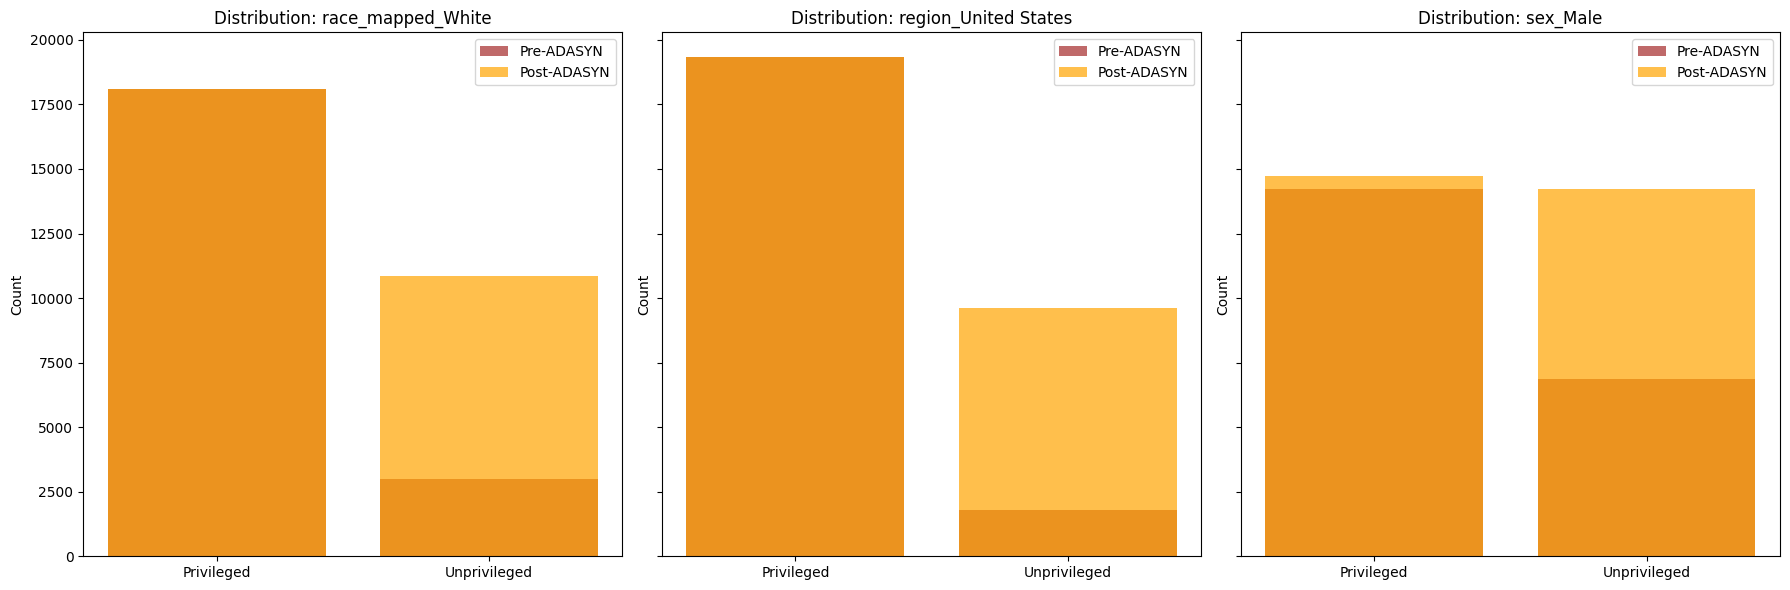

In [155]:
# Pre and post oversampling distributions
pre_oversampling = {'race_mapped_White': [18117, 2996], 'region_United States': [19327, 1786], 'sex_Male': [14237, 6876]}
post_oversampling = {'race_mapped_White': [18117, 10840], 'region_United States': [19327, 9630], 'sex_Male': [14720, 14237]}

# Convert to DataFrame for easier plotting
pre_df = pd.DataFrame(pre_oversampling, index=['Privileged', 'Unprivileged'])
post_df = pd.DataFrame(post_oversampling, index=['Privileged', 'Unprivileged'])

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for i, feature in enumerate(pre_oversampling.keys()):
    axs[i].bar(pre_df.index, pre_df[feature], alpha=0.7, label='Pre-ADASYN', color='brown')
    axs[i].bar(post_df.index, post_df[feature], alpha=0.7, label='Post-ADASYN', color='orange')
    axs[i].set_title(f'Distribution: {feature}', fontsize=12)
    axs[i].set_ylabel('Count', fontsize=10)
    axs[i].legend()

plt.tight_layout()
plt.show()

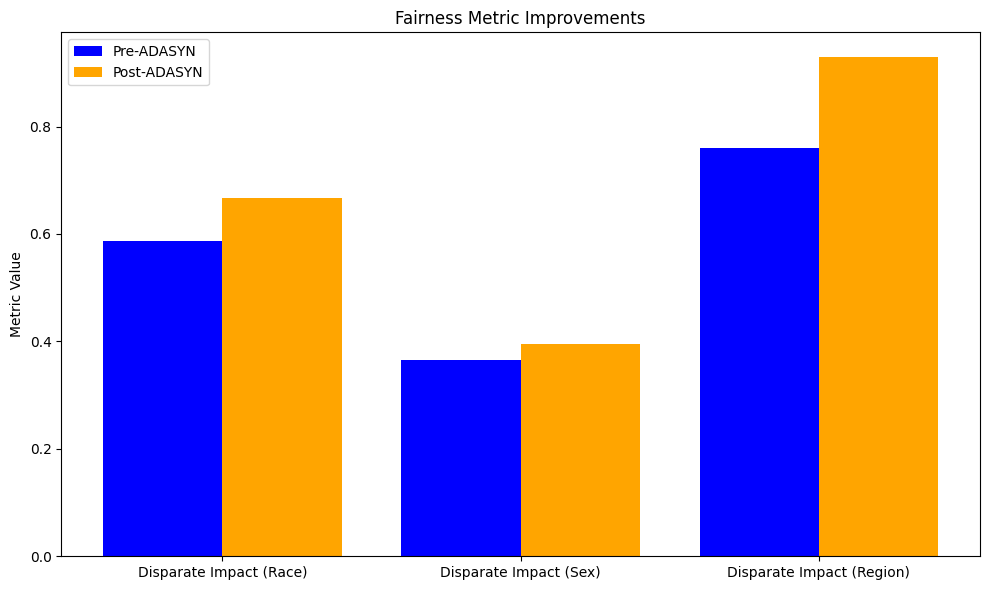

In [156]:
# Fairness metrics before and after
metrics = ['Disparate Impact (Race)', 'Disparate Impact (Sex)', 'Disparate Impact (Region)']
pre_metrics = [0.5869, 0.3652, 0.7602]
post_metrics = [0.6673, 0.3951, 0.9289]

x = np.arange(len(metrics))

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - 0.2, pre_metrics, width=0.4, label='Pre-ADASYN', color='blue')
ax.bar(x + 0.2, post_metrics, width=0.4, label='Post-ADASYN', color='orange')

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('Metric Value')
ax.set_title('Fairness Metric Improvements')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
x